# 1. Test Random Environment with OpenAI Gym

In [ ]:
!pip install tensorflow --quiet
!pip install gym --quiet
!pip install keras --quiet
!pip install keras-rl2 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 1.4 MB/s eta 0:00:00


In [ ]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random

In [ ]:
class ShowerEnv(Env):
    def __init__(self):
        # Actions we can take - down, stay, up
        self.action_space = Discrete(3)
        # Temperature array
        self.observation_space = Box(low=np.array([0]), high=np.array([100]))
        # Set start temp
        self.state = 38 + random.randint(-3,3)
        # Set shower length
        self.shower_length = 60

    def step(self, action):
        # Apply action
        # 0 -1 = -1 temperature
        # 1 -1 = 0
        # 2 -1 = 1 temperature
        self.state += action -1
        # Reduce shower length by 1 second
        self.shower_length -= 1

        # Calculate reward
        if self.state >=37 and self.state <=39:
            reward =1
        else:
            reward =0

        # Check if shower is done
        if self.shower_length <= 0:
            done = True
        else:
            done = False

        # Apply temperature noise
        # self.state += random.randint(-1,1)
        # Set placeholder for info
        info = {}

        # Return step information
        return self.state, reward, done, info

    def render(self):
        # Implement viz
        pass

    def reset(self):
        # Reset shower temperature
        self.state = 38 + random.randint(-3,3)
        # Reset shower time
        self.shower_length = 60
        return self.state


In [ ]:
env = ShowerEnv()

In [ ]:
env.observation_space.sample()

array([83.70233], dtype=float32)

In [ ]:
env.observation_space

Box(0.0, 100.0, (1,), float32)

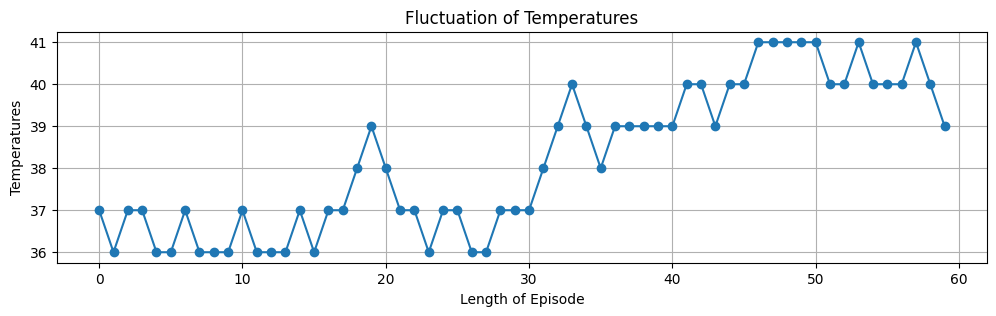

Episode:1 Score:29


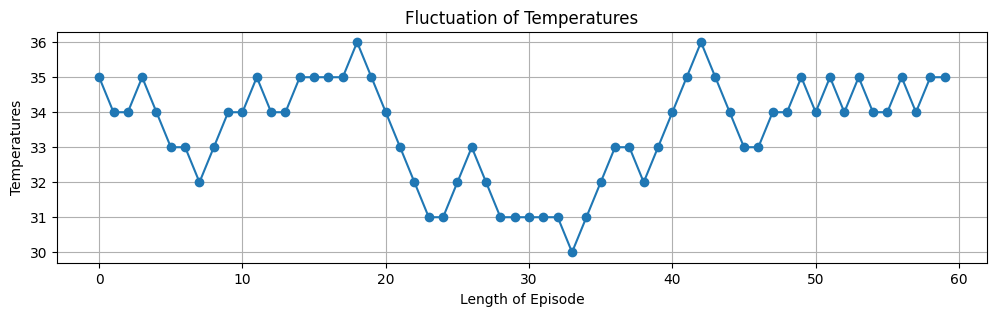

Episode:2 Score:0


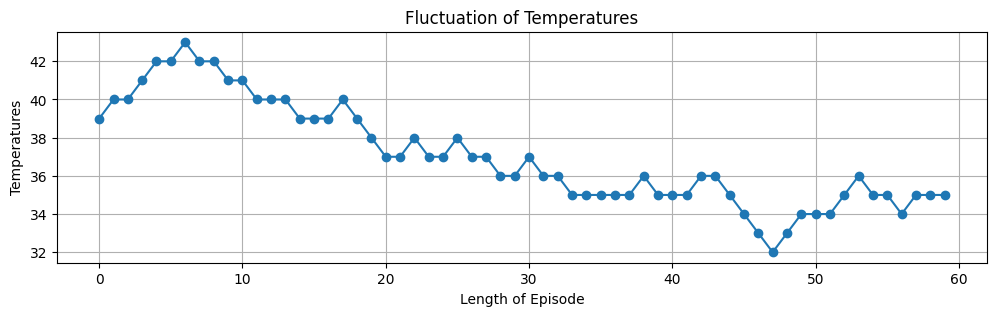

Episode:3 Score:15


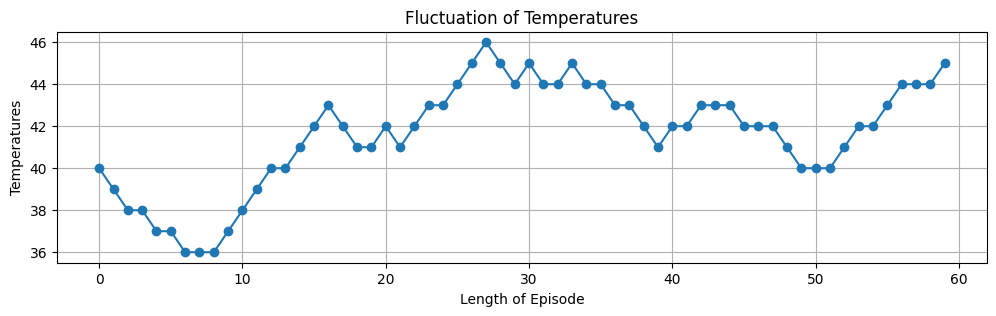

Episode:4 Score:8


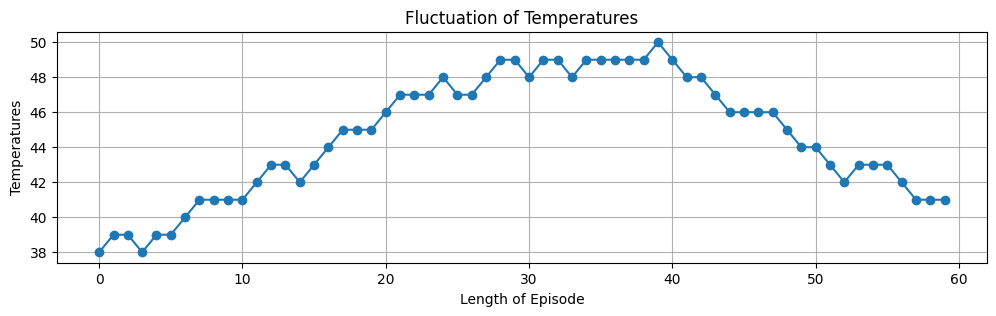

Episode:5 Score:6


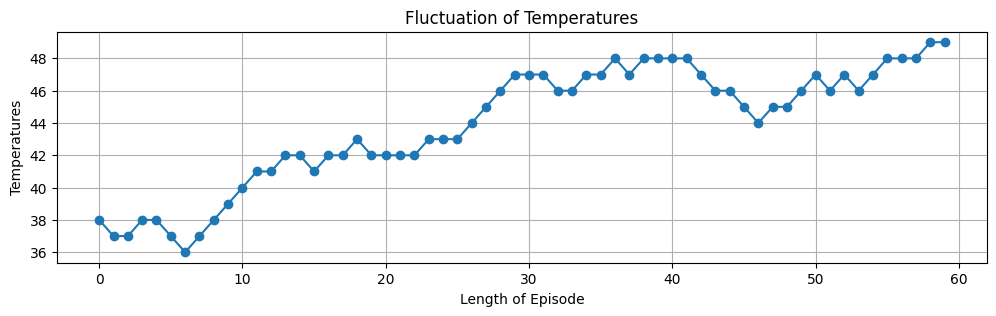

Episode:6 Score:9


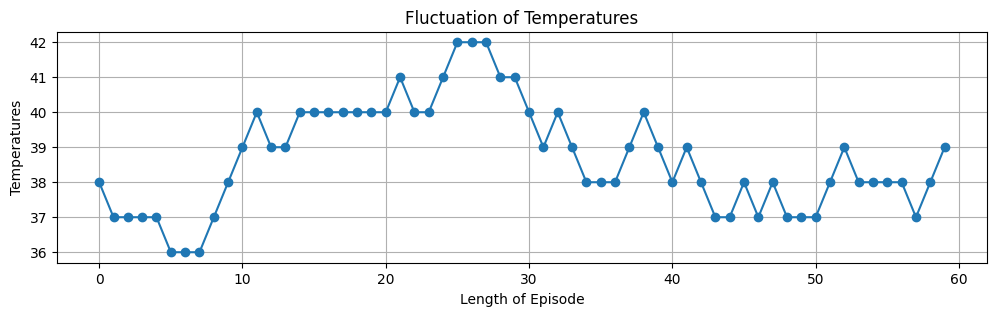

Episode:7 Score:37


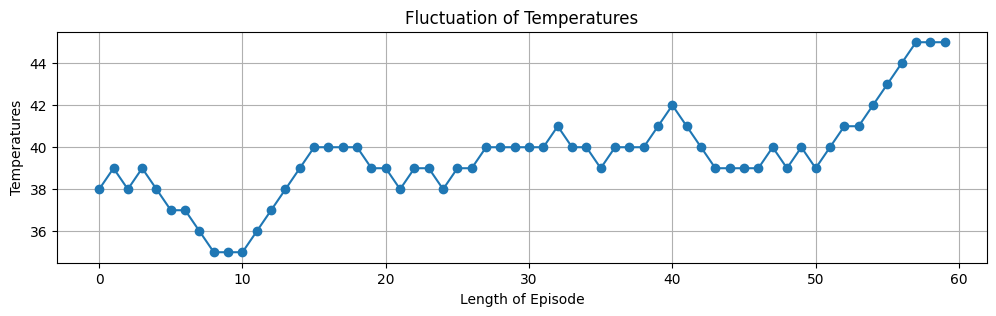

Episode:8 Score:25


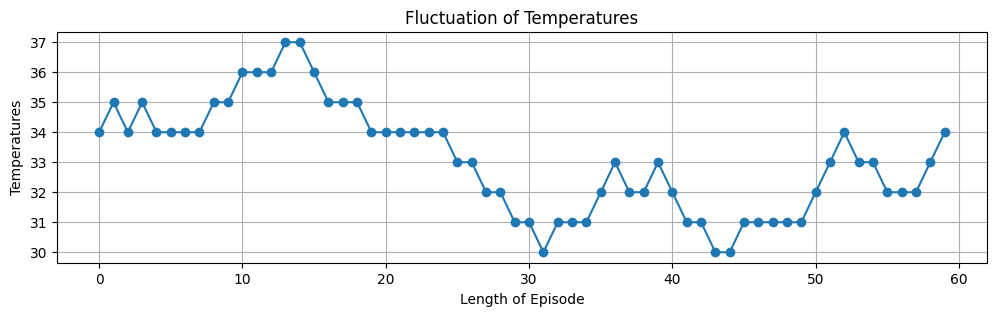

Episode:9 Score:2


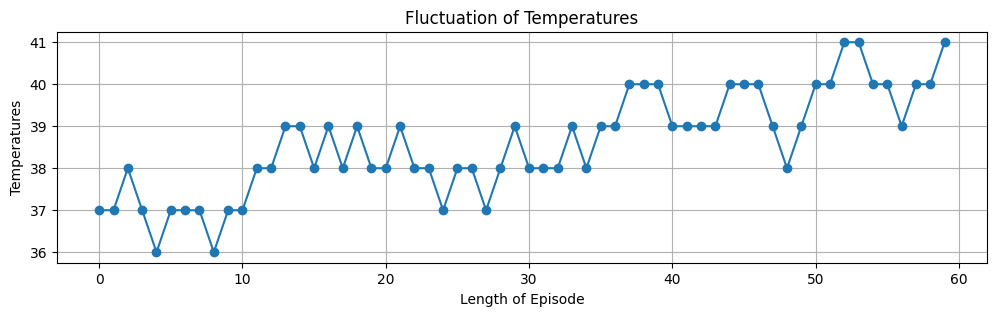

Episode:10 Score:43


In [ ]:
import matplotlib.pyplot as plt
episodes = 10
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    n_states = []

    while not done:
        # env.render()
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        n_states.append(n_state)
        score+=reward

    #Plot for Temperatures after each action performed
    x_values = range(len(n_states))
    plt.figure(figsize=(12,3))
    plt.plot(x_values, n_states, marker='o')
    plt.title('Fluctuation of Temperatures')
    plt.xlabel('Length of Episode')
    plt.ylabel('Temperatures')
    plt.grid(True)
    plt.show()

    print('Episode:{} Score:{}'.format(episode, score))

# 2. Create a Deep Learning Model with Keras

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes


In [ ]:
states = env.observation_space.shape
actions = env.action_space.n

In [ ]:
actions

3

In [ ]:
states

(1,)

In [ ]:
def build_model(states, actions):
    model = Sequential()
    model.add(Dense(24, activation='relu', input_shape=states))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [ ]:
# del build_model

In [ ]:
# model = build_model(states, actions)

In [ ]:
# model.summary()

# 3. Build Agent with Keras-RL

In [ ]:
import tensorflow as tf
from keras import __version__
tf.keras.__version__ = __version__

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

model = build_model(states, actions)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                48        
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
 dense_2 (Dense)             (None, 3)                 75        
                                                                 
Total params: 723 (2.82 KB)
Trainable params: 723 (2.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [ ]:
from tensorflow.keras.optimizers.legacy import Adam

dqn = build_agent(model, actions)
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)

Training for 50000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 98s 10ms/step - reward: -0.6470
166 episodes - episode_reward: -38.831 [-60.000, 12.000] - loss: 0.979 - mae: 6.292 - mean_q: -8.592

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 94s 9ms/step - reward: -0.6882
167 episodes - episode_reward: -41.305 [-60.000, 22.000] - loss: 1.787 - mae: 10.019 - mean_q: -14.310

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 94s 9ms/step - reward: -0.5852
167 episodes - episode_reward: -35.090 [-60.000, 26.000] - loss: 3.158 - mae: 13.187 - mean_q: -19.062

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 96s 10ms/step - reward: -0.5930
166 episodes - episode_reward: -35.482 [-60.000, 18.000] - loss: 2.751 - mae: 12.543 - mean_q: -17.976

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 97s 10ms/step - reward: -

In [ ]:
scores = dqn.test(env, nb_episodes=100, visualize=False)
print(np.mean(scores.history['episode_reward']))

Testing for 100 episodes ...
Episode 1: reward: 8.000, steps: 60
Episode 2: reward: 12.000, steps: 60
Episode 3: reward: -46.000, steps: 60
Episode 4: reward: -38.000, steps: 60
Episode 5: reward: -4.000, steps: 60
Episode 6: reward: 10.000, steps: 60
Episode 7: reward: 10.000, steps: 60
Episode 8: reward: -24.000, steps: 60
Episode 9: reward: 32.000, steps: 60
Episode 10: reward: -36.000, steps: 60
Episode 11: reward: 44.000, steps: 60
Episode 12: reward: 14.000, steps: 60
Episode 13: reward: -52.000, steps: 60
Episode 14: reward: 8.000, steps: 60
Episode 15: reward: 44.000, steps: 60
Episode 16: reward: -6.000, steps: 60
Episode 17: reward: 8.000, steps: 60
Episode 18: reward: -10.000, steps: 60
Episode 19: reward: -28.000, steps: 60
Episode 20: reward: -16.000, steps: 60
Episode 21: reward: -28.000, steps: 60
Episode 22: reward: 4.000, steps: 60
Episode 23: reward: -54.000, steps: 60
Episode 24: reward: -48.000, steps: 60
Episode 25: reward: 22.000, steps: 60
Episode 26: reward: 4.0

In [ ]:
_ = dqn.test(env, nb_episodes=15, visualize=False)

Testing for 15 episodes ...
Episode 1: reward: -60.000, steps: 60
Episode 2: reward: -22.000, steps: 60
Episode 3: reward: -2.000, steps: 60
Episode 4: reward: -28.000, steps: 60
Episode 5: reward: -20.000, steps: 60
Episode 6: reward: -56.000, steps: 60
Episode 7: reward: 34.000, steps: 60
Episode 8: reward: -40.000, steps: 60
Episode 9: reward: -34.000, steps: 60
Episode 10: reward: -40.000, steps: 60
Episode 11: reward: -46.000, steps: 60
Episode 12: reward: -2.000, steps: 60
Episode 13: reward: -38.000, steps: 60
Episode 14: reward: -8.000, steps: 60
Episode 15: reward: -16.000, steps: 60


# 4. Reloading Agent from Memory

In [ ]:
dqn.save_weights('dqn_weights.h5f', overwrite=True)

In [ ]:
del model
del dqn
del env

In [ ]:
import gym
env = gym.make('CartPole-v0', new_step_api=True)
actions = env.action_space.n
states = env.observation_space.shape
model = build_model(states, actions)
dqn = build_agent(model, actions)
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [ ]:
dqn.load_weights('dqn_weights.h5f')

ValueError: ignored

In [ ]:
_ = dqn.test(env, nb_episodes=15, visualize=True)